# Übung 7: Snakes

Luca Rava & Raphael Heer

##  Aufgabe 2: Kantenbild

Erstellen Sie in einem weissen Hintergrund ein schwarzes Objekt mit den Umrissen der
Abbildung 1 (Halten Sie sich dabei an den Massstab und verwenden Sie R = 32 Pixel).

In [185]:
# OpenCV needs to be included first
import cv2
import numpy as np

# for displaying images in jupyter

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi']= 400


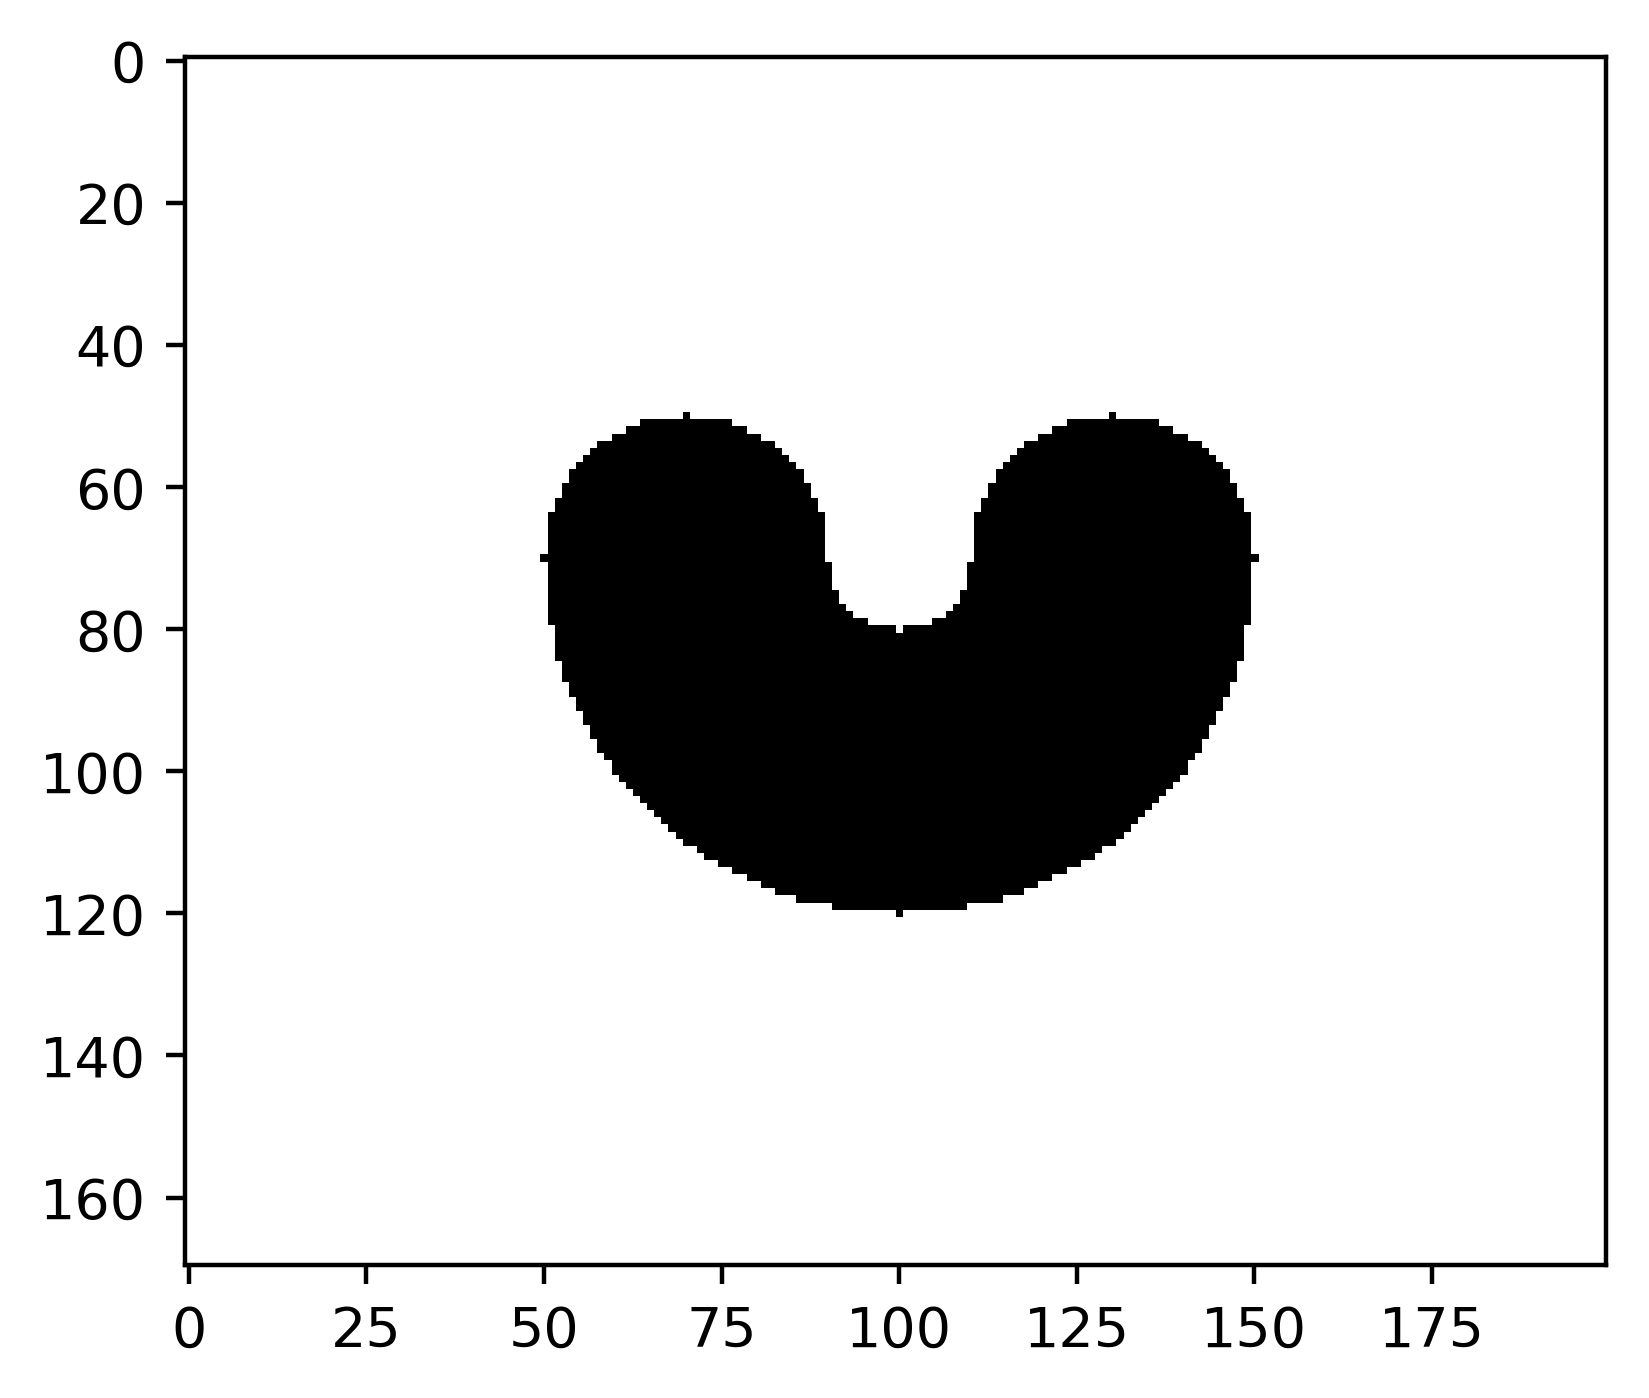

In [186]:
R = 50
M = 170
N = 4*R
f = np.ones((M,N))
for i in range(M):
    for j in range(N):
        cond = 7*R/5
        cond1 = (i-7*R/5)**2 + (j-2*R)**2
        cond2 = (i-7*R/5)**2 + (j-7*R/5)**2
        cond3 = (i-7*R/5)**2 + (j-13*R/5)**2
        if(cond1 <= R**2 and i >= cond):
            f[i,j]=0
        if(cond2 <= (2*R/5)**2 and i < cond):
            f[i,j]=0
        if(cond3 <= (2*R/5)**2 and i < cond):
            f[i,j]=0
        if(cond1 <= (R/5)**2 and i >= cond):
            f[i,j]=1
plt.imshow(f, cmap='gray')

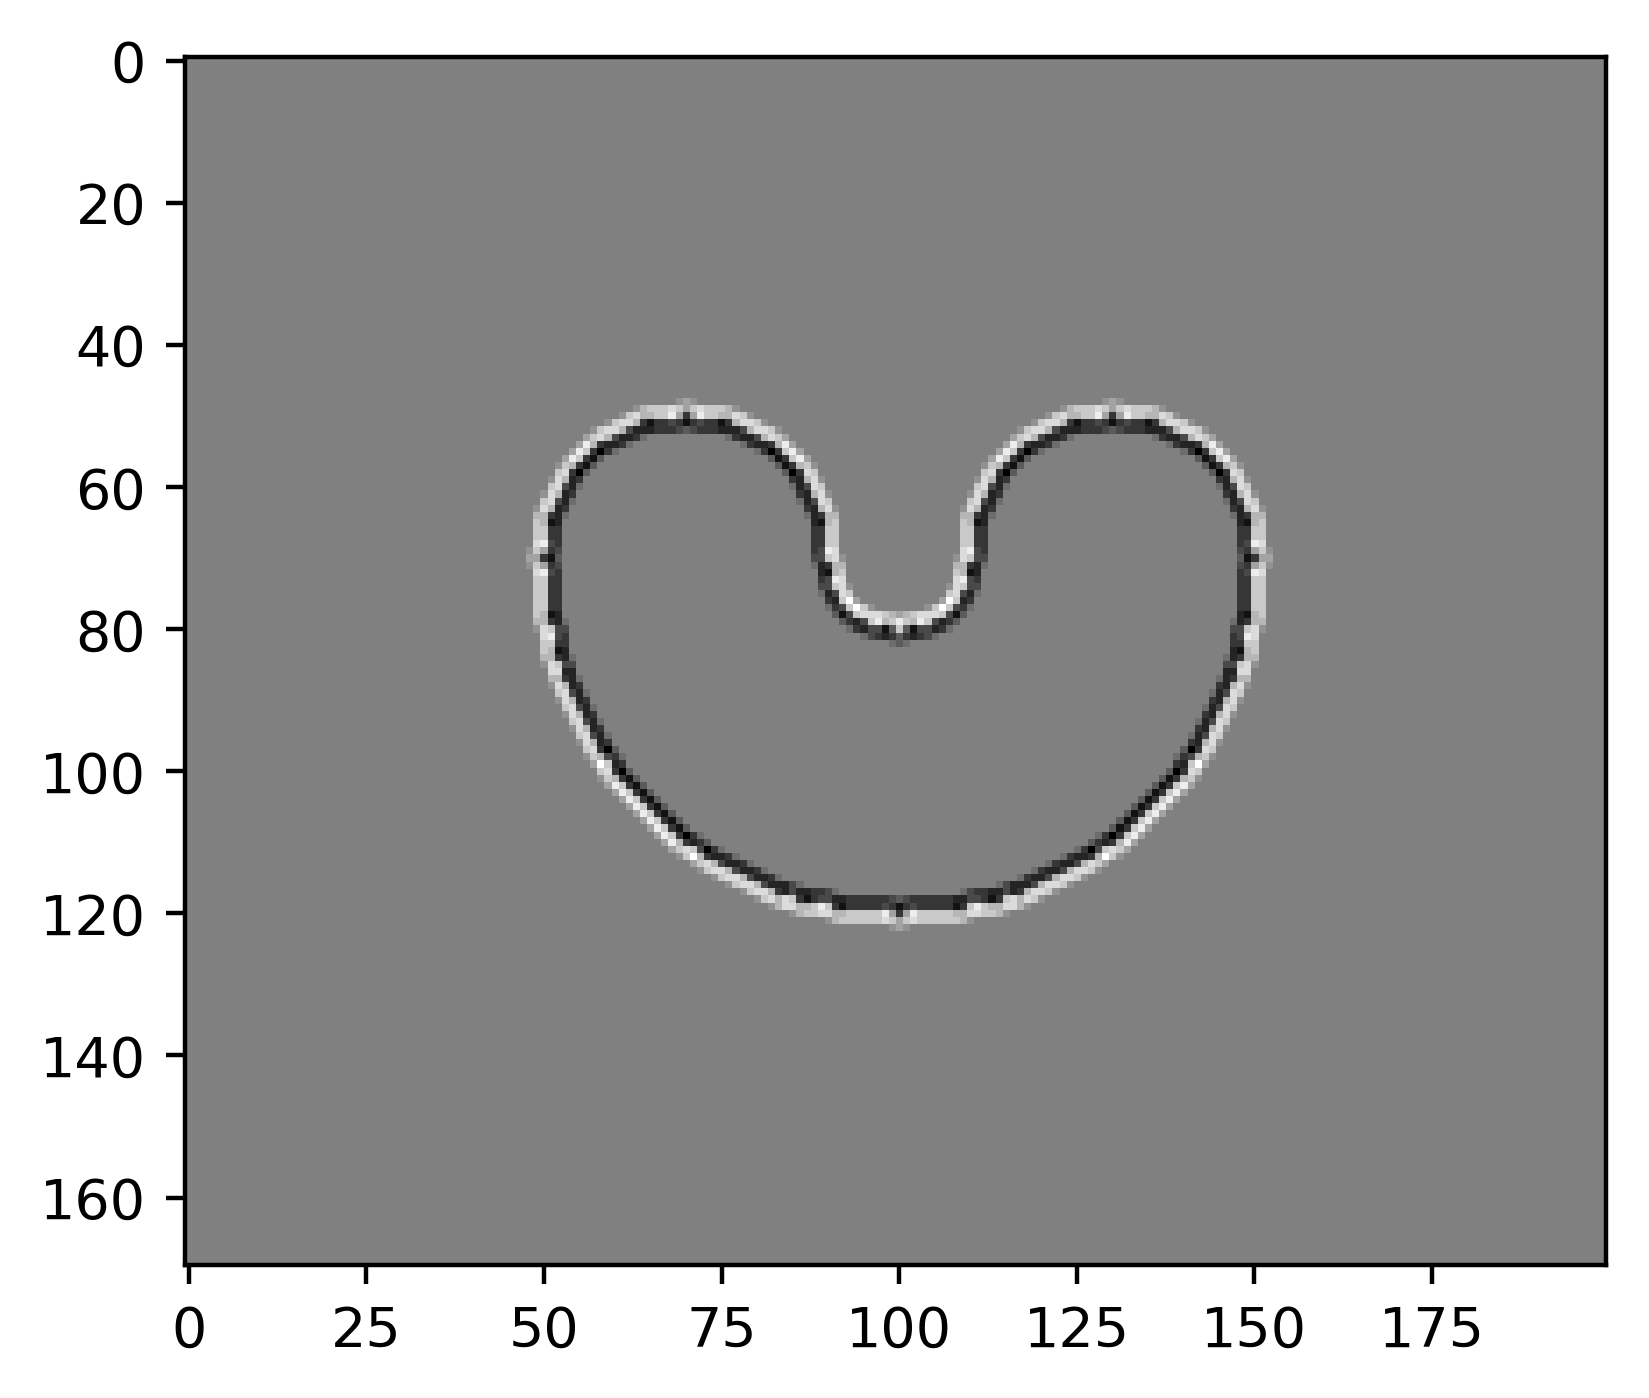

In [187]:
gaussian = cv2.GaussianBlur(f,(3,3),0)
gradient = cv2.Laplacian(gaussian,cv2.CV_64F)
potential = -gradient
plt.imshow(potential, cmap='gray')

## Aufgabe 3: Literaturstudium

Ziel einer Snake ist es, ihre Energie in der räumlichen Domäne funktional zu minimieren.
Bei Schwarzweiss-Zeichnungen werdn für die externe Energie die Funktionen I(x, y) und G_sig(x, y) * I(x, y) eingesetzt.
Um das Minimum funktional bestimmen zu können, wird das Eulerverfahren verwenden, indem man die Gleichung nach F_intern + F_extern = 0 löst. Dabei wird zum Lösen des Problem die Funktion x in der Abhängigkeit der Zeit gestellt, welche

Bei einer Snake geht es darum, das Energie Funktional in der räumlichen Domäne zu minimieren. Speziell bei
Schwarzweiss-Zeichnungen ist, dass dort für die externen Energien die Funktionen I(x, y) und G_sig(x, y) * I(x, y)
eingesetzt werden können. Dabei ist es wichtig, dass die Snake, die das Energie Funktional minimiert, die Euler
Gleichung erfüllt. Diese kann man sich dann vorstellen als F_intern + F_extern = 0. Zum Lösen des Problems wird eine
Funktion x in Abhängigkeit der Zeit gestellt, die mit Hilfe der partiellen Ableitungen das Minimum des Energie Funktionals
findet

## Aufgabe 4: Numerische Lösung der PDE für den GVF

In [188]:
def BoundMirrorExpand(A):
    M = A.shape[0]
    N = A.shape[1]
    
    B = np.zeros((M+2,N+2))
        
    B[1:M+1, 1:N+1] = A
    
    #Mirror Corners
    B[0,0] = B[2,2]
    B[M+1,0] = B[2,2]     
    B[0,N+1] = B[M-1,N-1]   
    B[M+1,N+1] = B[M-1,N-1]
    
    # Mirror top and bottom boundary
    for i in range(N):
        B[0, i+1] = B[2,i+1]
        B[M+1, i+1] = B[M-1,i+1]
        
    # mirror left and right boundary
    for i in range(M):
        B[i+1, 0] = B[i+1,2]
        B[i+1, N+1] = B[i+1,N-1]
    
    return B

In [189]:
def BoundMirrorEnsure(A):
    M = A.shape[0]
    N = A.shape[1]
        
    B = A
    
    #Mirror Corners
    B[0,0] = B[2,2]
    B[M-1,0] = B[2,2]     
    B[0,N-1] = B[M-3,N-3]   
    B[M-1,N-1] = B[M-3,N-3]
    
    # Mirror top and bottom boundary
    for i in range(N-2):
        B[0, i+1] = B[2,i+1]
        B[M-1, i+1] = B[M-3,i+1]
        
    # mirror left and right boundary
    for i in range(M-2):
        B[i+1, 0] = B[i+1,2]
        B[i+1, N-1] = B[i+1,N-3]
    
    return B

In [190]:
def BoundMirrorShrink(A):
    M = A.shape[0]
    N = A.shape[1]
    
    B = np.zeros((M-2,N-2))
    
    #Mirror Corners
    for i in range(M-2):
        for j in range(N-2):
            B[i,j] = A[i+1,j+1]
            
    return B

In [191]:
def GVF(f, mu, ITER):
    M, N = f.shape
    #fmin = min(f)
    #fmax = max(f)
    #f = (f-fmin)/(fmax-fmin)
    
    f = BoundMirrorExpand(f)  #define function
    fx = cv2.Sobel(f,cv2.CV_64F,1,0,ksize=5)
    fy = cv2.Sobel(f,cv2.CV_64F,0,1,ksize=5)
    u = fx
    v = fy
    SqrMagf = np.add(np.multiply(fx,fx),np.multiply(fy,fy))
    
    for i in range(ITER):
        u = BoundMirrorEnsure(u)
        v = BoundMirrorEnsure(v)
        u = u + mu*4*cv2.Laplacian(u,cv2.CV_64F) - np.multiply(SqrMagf,(u-fx))
        v = v + mu*4*cv2.Laplacian(v,cv2.CV_64F) - np.multiply(SqrMagf,(v-fx))

    u = BoundMirrorShrink(u)
    v = BoundMirrorShrink(v)
    
    return u, v

C:\Users\lucar\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in square
  This is separate from the ipykernel package so we can avoid doing imports until


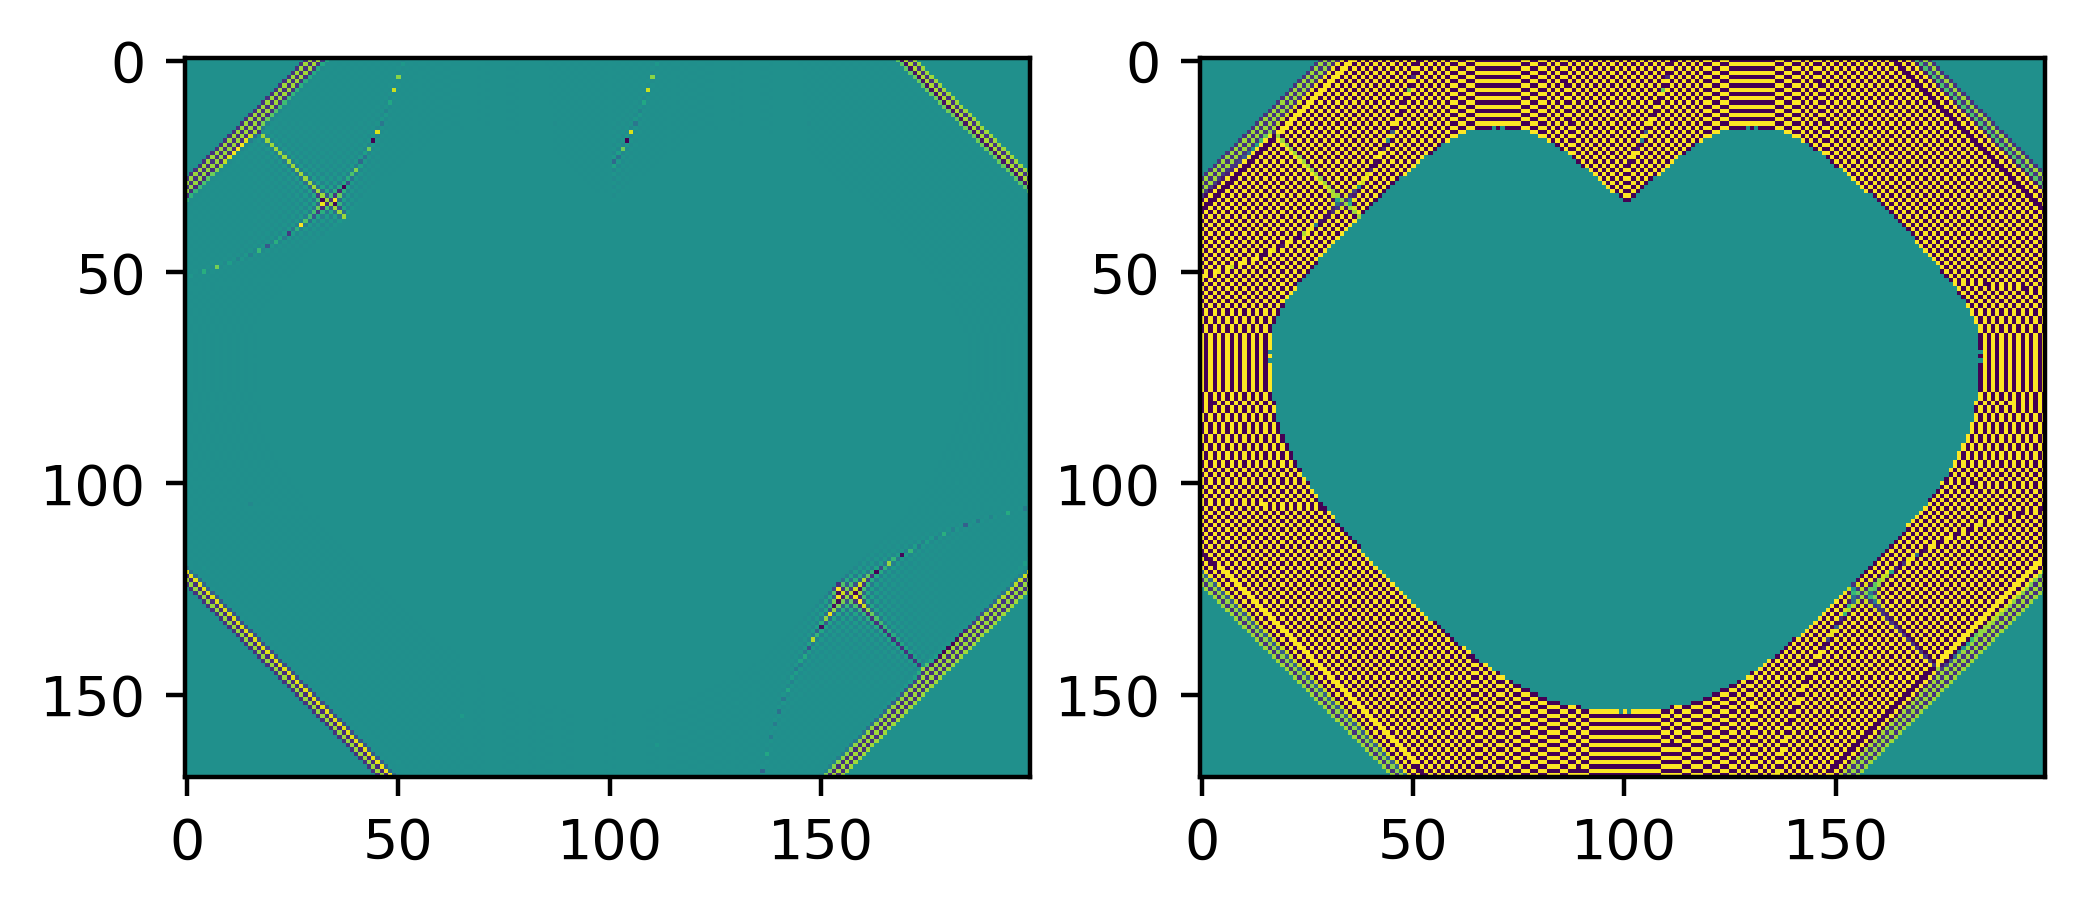

In [270]:
#Compute the GVF of the edge map f
u, v = GVF(f,0.2,80)
mag = np.sqrt(np.add(u**2,v**2))

px = u/(mag+1e-10)
py = v/(mag+1e-10)

plt.subplot(1,2,1)
plt.imshow(px)
plt.subplot(1,2,2)
plt.imshow(py)

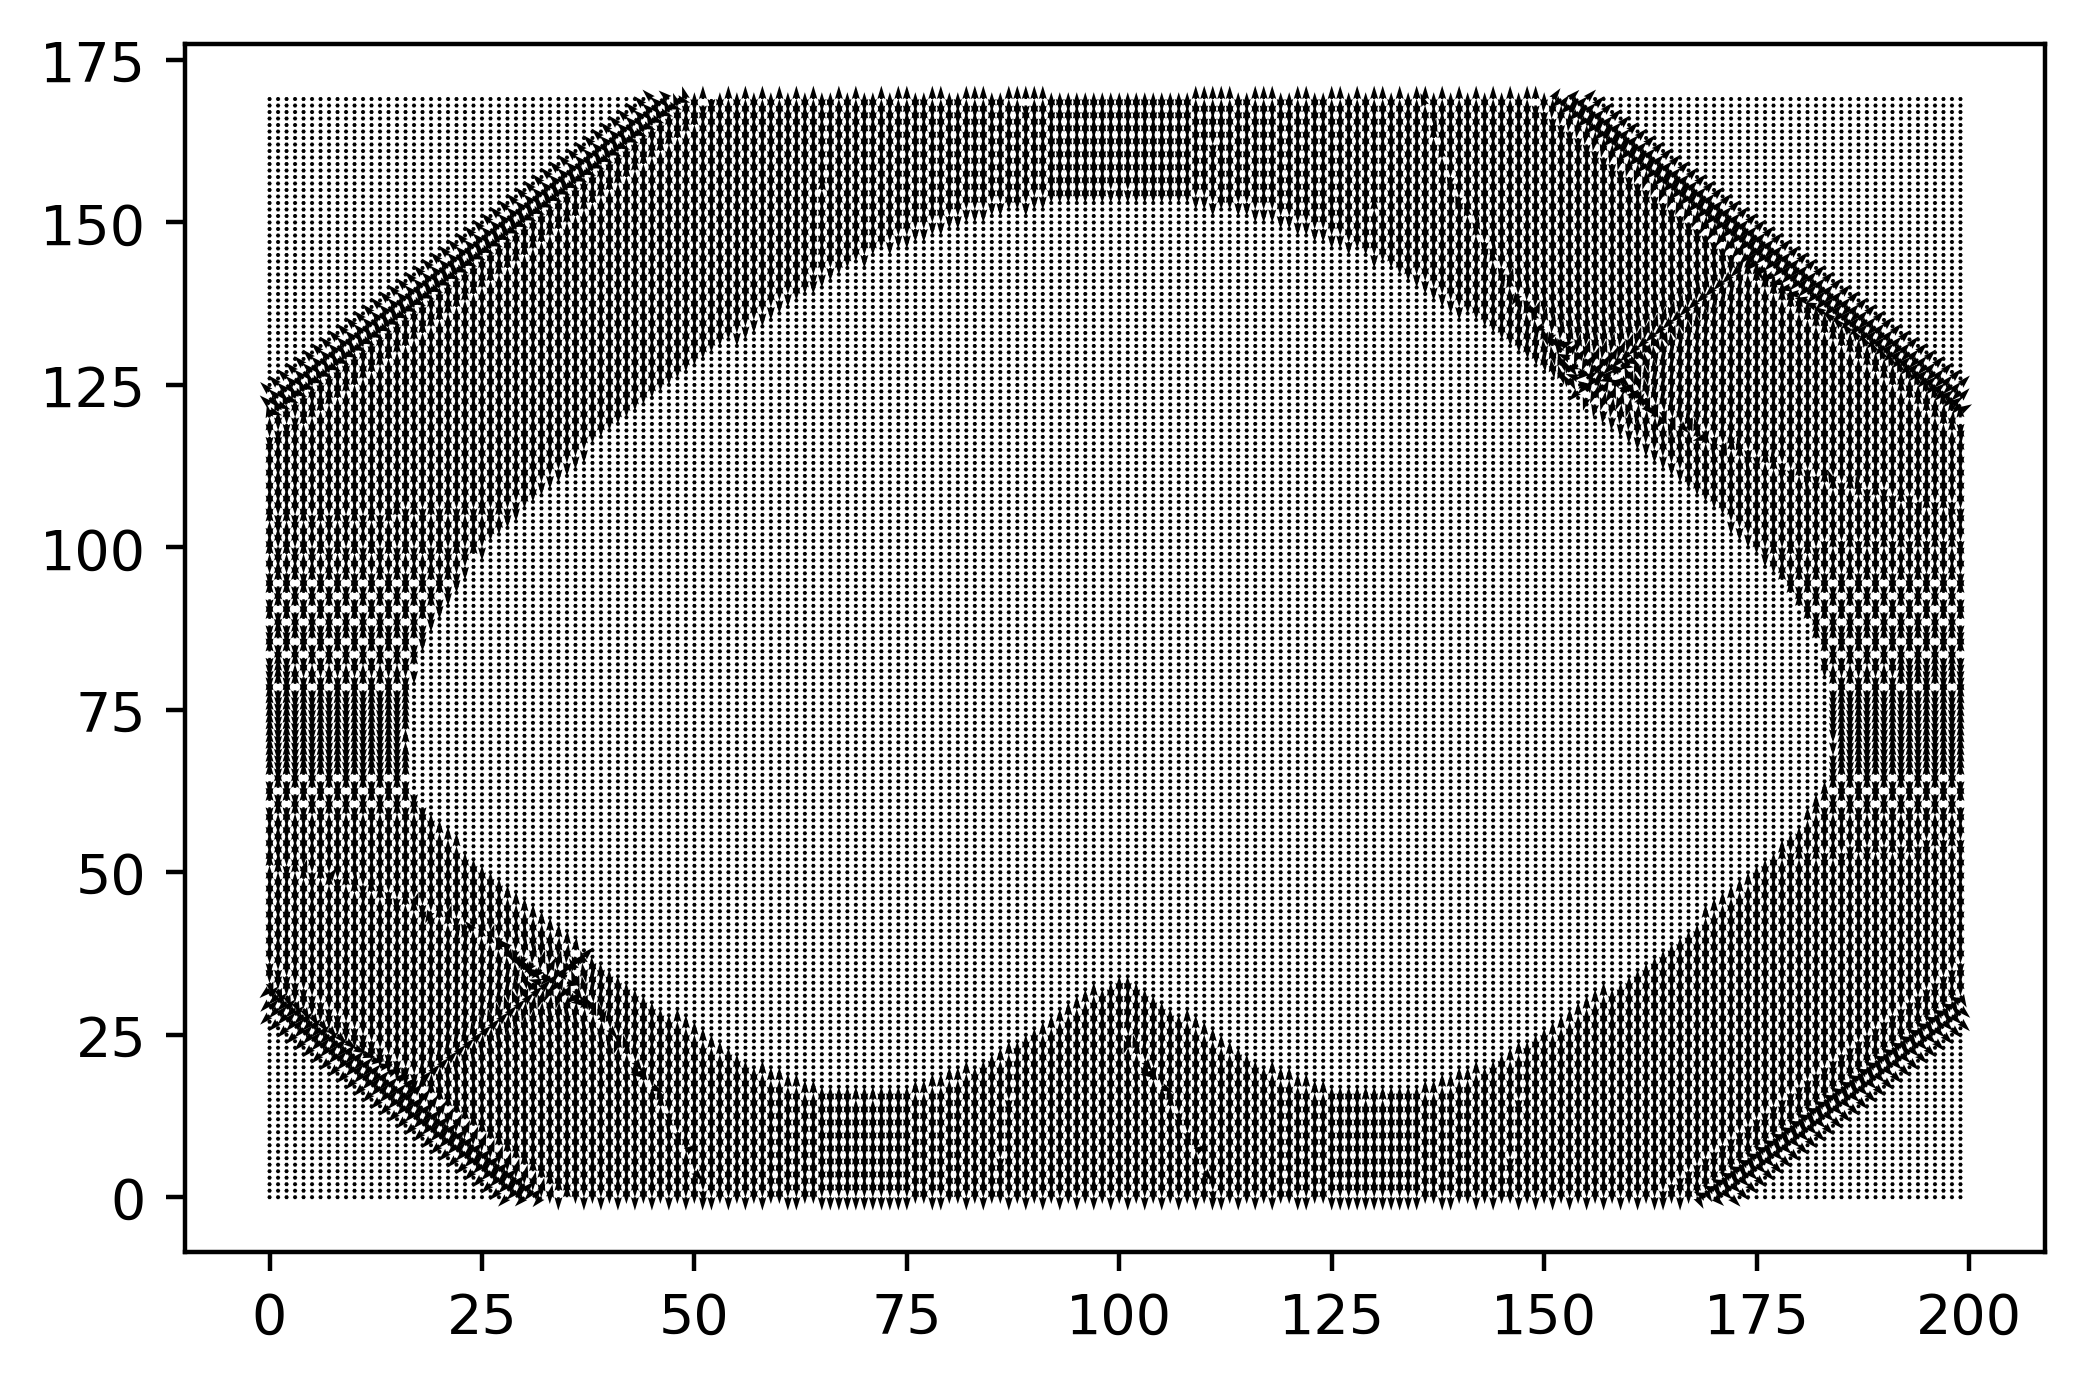

In [271]:
plt.quiver(px,py)